In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from collections import defaultdict
import pandas as pd


from math import ceil
from matplotlib.lines import Line2D
import networkx as nx
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from copy import deepcopy
from glob import glob


from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import LinearAutoregressiveHMM

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from fitting_functions import cross_validate_armodel, compute_inputs

# Custom functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from one_functions_generic import prepro

one = ONE()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
#data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']
       # var_names = ['avg_wheel_vel', 'whisker_me']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

List available mice

In [3]:
# Save data of all sessions for latter
mouse_names = []

for m, mat in enumerate(design_matrices):
    
    mouse_name = design_matrices[m][51:-4]
    if m == 0:
        mouse_names = mouse_name
    else:
        mouse_names = np.hstack((mouse_names, mouse_name))

## Preprocess list of design matrices

- Each session is saved under the mouse name; concatenated with other sessions of the same mouse;
- Only data up to trial 90 is kept;
- Data is normalized and standardized

In [4]:

# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for mouse_name in mouse_names:
    for m, mat in enumerate(design_matrices):
        
        if (mouse_name in mat) & (len(mouse_name) > 0): 
            
            # Trials data
            session = design_matrices[m][14:50]
                
            session_trials = one.load_object(session, obj='trials', namespace='ibl')
            session_trials = session_trials.to_df()
            session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
            session_start = list(session_trials['stimOn_times'])[0]

            # Get time of last unbiased trial
            unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
            time_trial_90 = list(unbiased['stimOff_times'])[-1]
            
            big_design_matrix = pickle.load(open(mat, "rb"))
            design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
            design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
            design_matrix = design_matrix.dropna()
        
            # Keep only first 90 trials
            design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
            unbiased_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]
            training_set = np.array(design_matrix[var_names]).copy() 
            
            if len(training_set) > 0:
                # Standardization using StandardScaler
                scaler = StandardScaler()
                standardized = scaler.fit_transform(training_set)
                # Normalize between 0 and 1
                normalizer = Normalizer().fit(standardized)
                normalized = normalizer.transform(standardized)
            
            # Save results per mouse
            matrix_all[mouse_name].append(normalized)
            session_all[mouse_name].append(unbiased_trials)    
            matrix_all_unnorm[mouse_name].append(design_matrix) 
            
# Collapse multiple sessions per mouse
for mouse in np.unique(mouse_names):
    if len(np.where(mouse_names==mouse)[0]) > 1 and len(mouse) > 0:
        matrix_all[mouse] = np.vstack(matrix_all[mouse])
        matrix_all_unnorm[mouse] = np.vstack(matrix_all_unnorm[mouse])
        session_all[mouse] = pd.concat(session_all[mouse], ignore_index=True)

## Fit Autoregressive HMM

### Parameters for fit

In [5]:
num_iters = 100
num_train_batches = 5
method = 'kmeans'
stickiness = 5000   # TODO: need to get stickiness parameter from saved results as well

In [6]:
filename = open('best_results', 'rb')
best_fits = pickle.load(filename)

# Loop through mice
for m, mouse_name in enumerate(np.unique(mouse_names)[0:2]):
    if len(mouse_name) > 0:
        
        order = np.where(best_fits['mouse_names']==mouse_name)[0]
        num_states = int(best_fits['best_state'][order][0])
        num_lags = int(best_fits['best_lag'][order][0])
        
        # Get mouse data
        session_trials = session_all[mouse_name]
        design_matrix = matrix_all[mouse_name]
        unnorm_mat = matrix_all_unnorm[mouse_name]  
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]
            
        " Fit model with cross-validation"
        # Prepare data for cross-validation
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
        
        # Initialize model with Kmeans
        test_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags, transition_matrix_stickiness=stickiness)
        init_params, props = test_arhmm.initialize(key=jr.PRNGKey(1), method=method, emissions=shortened_array)  # for now all data
        
        # Compute inputs for required timelags
        my_inputs = compute_inputs(shortened_array, num_lags, emission_dim)
        train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
        
        # Fit model to all data with cross-validation
        val_lls, fit_params, init_params, baseline_lls = cross_validate_armodel(test_arhmm, 
                                                                              jr.PRNGKey(0), shortened_array, train_emissions, train_inputs, method, num_train_batches)

        " Re-fit with parameters of best fold "
        # Find best fold
        use_fold = np.where(val_lls==np.nanmax(val_lls))[0][0]
        print(use_fold)
        
        # Find parameters for best fold
        initial_probs = fit_params[0].probs[use_fold]
        transition_matrix = fit_params[1].transition_matrix[use_fold]
        emission_weights = fit_params[2].weights[use_fold]
        emission_biases = fit_params[2].biases[use_fold]
        emission_covariances = fit_params[2].covs[use_fold]        
        
        # Initialize new hmm
        new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags)
        best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,               
                                        emission_weights=emission_weights,
                                        emission_biases=emission_biases, 
                                        emission_covariances=emission_covariances,
                                        emissions=shortened_array)  # not sure if I need to include  

        # Get state estimates for validation data
        most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [32]:
from cytoolz import sliding_window
def get_transitions(label_sequence):
    """Get the syllable transitions and their locations.

    Parameters
    ----------
    label_sequence : np.ndarray
        the sequence of syllable labels for a recording

    Returns
    -------
    transitions : np.ndarray
        the sequence of syllable transitions
    locs : np.ndarray
        the locations of the syllable transitions
    """

    arr = deepcopy(label_sequence)

    # get syllable transition locations
    locs = np.where(arr[1:] != arr[:-1])[0] + 1
    transitions = arr[locs]

    return transitions, locs

def n_gram_transition_matrix(labels, n=2, max_label=99):
    """The transition matrix for n-grams.

    Parameters
    ----------
    labels : list or np.ndarray
        recording state lists
    n : int, optional
        the number of successive states in the sequence, by default 2
    max_label : int, optional
        the maximum number of the syllable labels to include, by default 99

    Returns
    -------
    trans_mat : np.ndarray
        the transition matrices for the n-grams
    """
    trans_mat = np.zeros((max_label,) * n, dtype="float")
    for loc in sliding_window(n, labels):
        if any(l >= max_label for l in loc):
            continue
        trans_mat[loc] += 1
    return trans_mat


def normalize_transition_matrix(init_matrix, normalize):
    """Normalize the transition matrices.

    Parameters
    ----------
    init_matrix : numpy.ndarray
        the initial transition matrix to be normalized
    normalize : str
        the method to normalize the transition matrix

    Returns
    -------
    init_matrix : numpy.ndarray
        the trnasition matrix normalized by the method specified
    """
    if normalize is None or normalize not in ("bigram", "rows", "columns"):
        return init_matrix
    if normalize == "bigram":
        init_matrix /= init_matrix.sum()
    elif normalize == "rows":
        init_matrix /= init_matrix.sum(axis=1, keepdims=True)
    elif normalize == "columns":
        init_matrix /= init_matrix.sum(axis=0, keepdims=True)

    return init_matrix


transitions = get_transitions(most_likely_states)[0]
max_syllable = len(np.unique(most_likely_states))
init_matrix = n_gram_transition_matrix(transitions, n=2, max_label=max_syllable)
n_gram_trans_mat = normalize_transition_matrix(init_matrix, 'bigram')

Text(0.5, 0, 'Outgoing state')

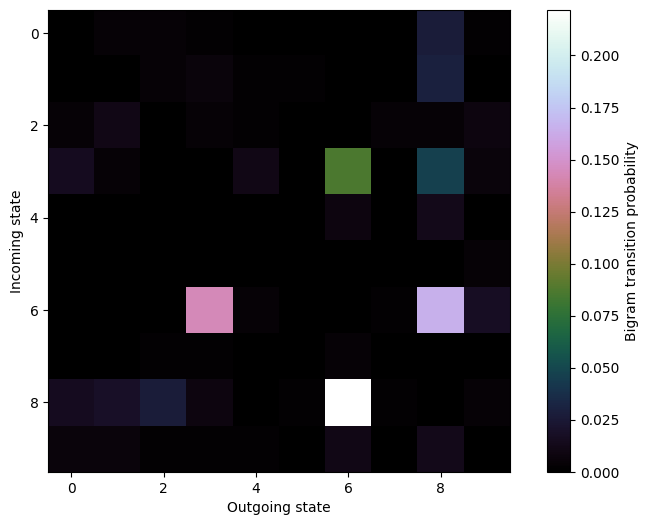

In [173]:
# def visualize_transition_bigram(
#     project_dir,
#     model_name,
#     group,
#     trans_mats,
#     syll_include,
#     save_dir=None,
#     normalize="bigram",
#     figsize=(12, 6),
#     show_syllable_names=True,
# ):
"""Visualize the transition matrices for each group.

Parameters
----------
group : list or np.ndarray
    the groups in the project
trans_mats : list
    the list of transition matrices for each group
normalize : str, optional
    the method to normalize the transition matrix, by default 'bigram'
figsize : tuple, optional
    the figure size, by default (12,6)
show_syllable_names : bool, optional
    whether to show just syllable indexes (False) or syllable indexes and
    names (True)
"""
# if show_syllable_names:
#     syll_names = get_syllable_names(project_dir, model_name, syll_include)
# else:
#     syll_names = [f"{ix}" for ix in syll_include]
save_dir=None
normalize="bigram"
figsize=(12, 6)
show_syllable_names=True
syll_names = most_likely_states
trans_mat = n_gram_trans_mat
# infer max_syllables
max_syllables = trans_mat.shape[0]

fig, ax = plt.subplots(1, 1, figsize=figsize, sharex=False, sharey=True)
title_map = dict(bigram="Bigram", columns="Incoming", rows="Outgoing")
color_lim = max([x.max() for x in trans_mat])

h = ax.imshow(
    trans_mat[:max_syllables, :max_syllables],
    cmap="cubehelix",
    vmax=color_lim)
ax.set_ylabel("Incoming state")
# plt.yticks(np.arange(len(syll_include)), syll_names)
cb = fig.colorbar(h, ax=ax, fraction=0.046, pad=0.04)
cb.set_label(f"{title_map[normalize]} transition probability")
ax.set_xlabel("Outgoing state")
# ax.set_title(g)
# axs.set_xticks(np.arange(len(syll_include)), syll_names, rotation=90)


In [ ]:
def plot_transition_graph_group(
    project_dir,
    model_name,
    groups,
    trans_mats,
    usages,
    syll_include,
    save_dir=None,
    layout="circular",
    node_scaling=2000,
    show_syllable_names=False,
):
    """Plot the transition graph for each group.

    Parameters
    ----------
    groups : list
        the list of groups to plot
    trans_mats : list
        the list of transition matrices for each group
    usages : list
        the list of syllable usage for each group
    layout : str, optional
        the layout of the graph, by default 'circular'
    node_scaling : int, optional
        the scaling factor for the node size, by default 2000,
    show_syllable_names : bool, optional
        whether to show just syllable indexes (False) or syllable indexes and
        names (True)
    """
    # if show_syllable_names:
    #     syll_names = get_syllable_names(project_dir, model_name, syll_include)
    # else:
    #     syll_names = [f"{ix}" for ix in syll_include]

    syll_names = most_likely_states
    usages = 
    

    n_row = ceil(len(groups) / 2)
    fig, all_axes = plt.subplots(n_row, 2, figsize=(20, 10 * n_row))
    ax = all_axes.flat

    for i in range(len(groups)):
        G = nx.from_numpy_array(trans_mats[i] * 100)
        widths = nx.get_edge_attributes(G, "weight")
        if layout == "circular":
            pos = nx.circular_layout(G)
        else:
            pos = nx.spring_layout(G)
        # get node list
        nodelist = G.nodes()
        # normalize the usage values
        sum_usages = sum(usages[i])
        normalized_usages = (
            np.array([u / sum_usages for u in usages[i]]) * node_scaling + 1000
        )
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=nodelist,
            node_size=normalized_usages,
            node_color="white",
            edgecolors="red",
            ax=ax[i],
        )
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=widths.keys(),
            width=list(widths.values()),
            edge_color="black",
            ax=ax[i],
            alpha=0.6,
        )
        nx.draw_networkx_labels(
            G,
            pos=pos,
            labels=dict(zip(nodelist, syll_names)),
            font_color="black",
            ax=ax[i],
        )
        ax[i].set_title(groups[i])
    # turn off the axis spines
    for sub_ax in ax:
        sub_ax.axis("off")




In [37]:


def concatenate_stateseqs(stateseqs, mask=None):
    """
    Concatenate state sequences, optionally applying a mask.

    Parameters
    ----------
    stateseqs: ndarray of shape (..., t), or dict or list of such arrays
        Batch of state sequences where the last dim indexes time, or a
        dict/list containing state sequences as 1d arrays.

    mask: ndarray of shape (..., >=t), default=None
        Binary indicator for which elements of `stateseqs` are valid,
        used in the case where `stateseqs` is an ndarray. If `mask`
        contains more time-points than `stateseqs`, the initial extra
        time-points will be ignored.

    Returns
    -------
    stateseqs_flat: ndarray
        1d array containing all state sequences
    """
    if isinstance(stateseqs, dict):
        stateseq_flat = np.hstack(list(stateseqs.values()))
    elif isinstance(stateseqs, list):
        stateseq_flat = np.hstack(stateseqs)
    elif mask is not None:
        stateseq_flat = stateseqs[mask[:, -stateseqs.shape[1] :] > 0]
    else:
        stateseq_flat = stateseqs.flatten()
    return stateseq_flat


def get_frequencies(stateseqs, mask=None, num_states=None, runlength=True):
    """
    Get state frequencies for a batch of state sequences.

    Parameters
    ----------
    stateseqs: ndarray of shape (..., t), or dict or list of such arrays
        Batch of state sequences where the last dim indexes time, or a
        dict/list containing state sequences as 1d arrays.

    mask: ndarray of shape (..., >=t), default=None
        Binary indicator for which elements of `stateseqs` are valid,
        used in the case where `stateseqs` is an ndarray. If `mask`
        contains more time-points than `stateseqs`, the initial extra
        time-points will be ignored.

    num_states: int, default=None
        Number of different states. If None, the number of states will
        be set to `max(stateseqs)+1`.

    runlength: bool, default=True
        Whether to count frequency by the number of instances of each
        state (True), or by the number of frames in each state (False).

    Returns
    -------
    frequencies: 1d array
        Frequency of each state across all state sequences

    Examples
    --------
    >>> stateseqs = {
        'name1': np.array([1, 1, 2, 2, 2, 3]),
        'name2': np.array([0, 0, 0, 1])}
    >>> get_frequencies(stateseqs, runlength=True)
    array([0.2, 0.4, 0.2, 0.2])
    >>> get_frequencies(stateseqs, runlength=False)
    array([0.3, 0.3, 0.3, 0.1])
    """
    stateseq_flat = concatenate_stateseqs(stateseqs, mask=mask).astype(int)

    if runlength:
        state_onsets = np.pad(np.diff(stateseq_flat).nonzero()[0] + 1, (1, 0))
        stateseq_flat = stateseq_flat[state_onsets]

    counts = np.bincount(stateseq_flat, minlength=num_states)
    frequencies = counts / counts.sum()
    return frequencies


usages = get_frequencies(most_likely_states, mask=None, num_states=None, runlength=True)
usages

array([0.04      , 0.04421053, 0.04      , 0.16842105, 0.02105263,
       0.00421053, 0.33263158, 0.00842105, 0.29894737, 0.04210526])

In [73]:
min_frequency = 0.0001  # very small value for now
layout="circular"
node_scaling=2000
show_syllable_names=False

(-1.5, 1.5)

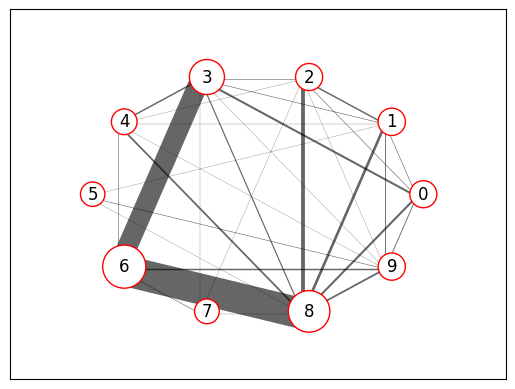

In [172]:
# syll_names = most_likely_states
transitions = get_transitions(most_likely_states)[0]
max_syllable = len(np.unique(most_likely_states))
init_matrix = n_gram_transition_matrix(transitions, n=2, max_label=max_syllable)
n_gram_trans_mat = normalize_transition_matrix(init_matrix, 'bigram')

usages = get_frequencies(most_likely_states, mask=None, num_states=None, runlength=True)
syll_include = np.where(usages > min_frequency)[0]
syll_names = [f"{ix}" for ix in syll_include]
trans_mat = n_gram_trans_mat


# n_row = ceil(len(groups) / 2)
# fig, all_axes = plt.subplots(1, 1, figsize=(20, 10 * 1))

fig, all_axes = plt.subplots()
# ax = all_axes.flat

# for i in range(len(groups)):
G = nx.from_numpy_array(trans_mat*100)  # * 100
widths = nx.get_edge_attributes(G, "weight")
if layout == "circular":
    pos = nx.circular_layout(G)
else:
    pos = nx.spring_layout(G)

correction = 1.6
new_pos = {0: [1.0000000e+00 - correction, 1.4702742e-08- correction],
1:[0.809017- correction  , 0.58778526- correction],
2: [0.30901698- correction, 0.95105655- correction],
3: [-0.30901702- correction,  0.95105649- correction],
4: [-0.80901699- correction,  0.58778526- correction],
5: [-9.99999988e-01- correction, -7.27200340e-08- correction],
6: [-0.80901693- correction, -0.58778529- correction],
7: [-0.30901711- correction, -0.95105646- correction],
8: [ 0.30901713- correction, -0.95105646- correction],
9: [ 0.80901694- correction, -0.58778529- correction]}

# get node list
nodelist = G.nodes()
# normalize the usage values
sum_usages = sum(usages)
normalized_usages = (
    np.array([u / sum_usages for u in usages]) * node_scaling +300
)  # * node_scaling + 1000
nx.draw_networkx_nodes(
    G,
    pos=pos,
    nodelist=nodelist,
    node_size=normalized_usages,
    node_color="white",
    edgecolors="red",
)
nx.draw_networkx_edges(
    G,
    pos=new_pos,
    edgelist=widths.keys(),
    width=list(widths.values()),
    edge_color="black",
    alpha=0.6,
)
nx.draw_networkx_labels(
    G,
    pos=pos,
    labels=dict(zip(nodelist, syll_names)),
    font_color="black",
)  #        ax=ax,
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
# # turn off the axis spines
# for sub_ax in ax:
#     sub_ax.axis("off")